# Part One
## Web Scraping and Data Cleaning

I known you can read the url directly from Pandas, but let's practice using Beautiful Soup. We'll use requests to get the html code from the url, then use Beatuiful Soup to find the table on the page. We'll then pass that table to pandas to make a dataframe

In [1]:
# import dependencies
from bs4 import BeautifulSoup
from pprint import pprint
import requests
import pandas as pd
import numpy as np

In [2]:
# define function to get html info using requests
def get_html(url):
    '''url and returns a beautiful soup object for that webpage'''
    r = requests.get(url)
    doc = r.content
    soup = BeautifulSoup(doc, 'lxml')
    return soup

In [3]:
# call function to 
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

In [4]:
# read html into bs object
soup = get_html(url)
# print(soup.prettify())

In [5]:
# get just the table on the wikipedia page
table = soup.find('table')
# print(table.prettify())

In [6]:
# cast the bs object for the table into a str so pandas can read it, then convert to df
df = pd.read_html(str(table), header=0)[0] # read_html returns a list of dfs. there should only be 1 table here, so index 0 should be the correct one
df.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


### Data Cleaning
Criteria:
* The dataframe will consist of three columns: PostalCode, Borough, and Neighborhood
* Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.
* More than one neighborhood can exist in one postal code area. For example, in the table on the Wikipedia page, you will notice that M5A is listed twice and has two neighborhoods: Harbourfront and Regent Park. These two rows will be combined into one row with the neighborhoods separated with a comma as shown in row 11 in the above table.
* If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough. So for the 9th cell in the table on the Wikipedia page, the value of the Borough and the Neighborhood columns will be Queen's Park.
* In the last cell of your notebook, use the .shape method to print the number of rows of your dataframe.

#### Data Exploration
Let's expore the data a little so we can see what we need to do. How many Boroughs are 'Not Assigned'? How many post codes have multiple neighborhoods?

In [7]:
# use .info() method to see how much data we have and if check for null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287 entries, 0 to 286
Data columns (total 3 columns):
Postcode         287 non-null object
Borough          287 non-null object
Neighbourhood    287 non-null object
dtypes: object(3)
memory usage: 6.8+ KB


In [8]:
# how many not assigned vlaues are there?
df['Borough'].value_counts()

Not assigned        77
Etobicoke           44
North York          38
Scarborough         37
Downtown Toronto    36
Central Toronto     17
West Toronto        13
York                 9
East Toronto         7
East York            6
Queen's Park         2
Mississauga          1
Name: Borough, dtype: int64

#### Let's drop all the rows that have a 'Not Assigned' Borrough

In [9]:
# filter out any rows where the Borough column is 'Not assigned'
df = df[df['Borough'] != 'Not assigned']
df['Borough'].value_counts() # verify value counts

Etobicoke           44
North York          38
Scarborough         37
Downtown Toronto    36
Central Toronto     17
West Toronto        13
York                 9
East Toronto         7
East York            6
Queen's Park         2
Mississauga          1
Name: Borough, dtype: int64

Next, let's find the rows where the neighbourhoods are 'Not assigned'. Once we've found those rows, we can set the 'Neighborhood' column equal to the 'Borough' column

In [10]:
# Find boroughs where the neighborhood is not assigned
no_neighborhood = df[df['Neighbourhood'] == 'Not assigned']
no_neighborhood

,Postcode,Borough,Neighbourhood
7,M7A,Queen's Park,Not assigned


#### Now that we know what rows to change, we can slice those rows and set the 'Neighbourhood' equal to the 'Borough'. There's technically only one row that we have to change for this data set, but this code would work in case there were multiple rows. It's good for practice.

In [11]:
# Find the indices of the desired rows
indices_to_change = no_neighborhood.index
# slice and change df
df.loc[indices_to_change, 'Neighbourhood'] = df.loc[indices_to_change, 'Borough']

# Verify Change
df[df['Postcode'] == "M7A"]

,Postcode,Borough,Neighbourhood
7,M7A,Queen's Park,Queen's Park


In [12]:
df.head(10)

,Postcode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M6A,North York,Lawrence Heights
6,M6A,North York,Lawrence Manor
7,M7A,Queen's Park,Queen's Park
9,M9A,Queen's Park,Queen's Park
10,M1B,Scarborough,Rouge
11,M1B,Scarborough,Malvern
13,M3B,North York,Don Mills North


The last step of the cleaning is to concactenate all neighbourhoods in each borough into one row. We can group by Postcode and then Borugh, then join each neighborhood in heaf group separated by ', '

In [13]:
# Group the df and get the series for 'Neighborhood'. Then join each str, separated vy ', '. Convert the new series to a df afterwards
clean_df = df.groupby(['Postcode', 'Borough'])['Neighbourhood'].apply(', '.join).to_frame()

# reset index
clean_df.reset_index(inplace=True)

clean_df.head(10)

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park"
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge"
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff, Cliffside West"


In [14]:
# display shape of df
clean_df.shape

(103, 3)

# Part Two
## Geocoding
We need to get coordinates (lattitude and longtitude) for each postal code. Geocoder wasn't working for me, and I tried other sources like geopy and mapbox with mixed results. Map box, was sucessful, but gave slightly different results from the provided csv. For grading simplicity and continuity, I'm going to use the csv.

After reding the data from the provided csv, Let's build a dataframe of coordinates for each unique postal code, then merge that df with the previously made df containing the borroughs and neighborhoods.

In [15]:
csv_path = 'https://cocl.us/Geospatial_data'
coordinate_df = pd.read_csv(csv_path)
coordinate_df.rename(columns={'Postal Code':'Postcode'}, inplace=True) # rename column so it matches previous df
coordinate_df.head()

,Postcode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [16]:
coordinate_df.shape

(103, 3)

In [17]:
# Merge dataframes
df = pd.merge(clean_df, coordinate_df, on='Postcode')
df.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [18]:
df.shape

(103, 5)

# Part 3
## Foursquare API call and clustering

Let's filter for only the top 50% most populated postal codes in Toronto. To do this, let's scrape more data from the 2016 Canadian census. We can join this data on the 'Postcode' column to get the population for each postcode.

In [19]:
census_data = 'https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/hlt-fst/pd-pl/Table.cfm?Lang=Eng&T=1201&SR=1&S=22&O=A&RPP=9999&PR=0'

In [20]:
# read the census page into BS object from function in part 1
census_soup = get_html(census_data)

# print(census_soup.prettify())

In [21]:
# find the table in the page
census_table = census_soup.find('table')

# print(census_table.prettify())

In [22]:
# read table into df
census_df = pd.read_html(str(census_table), header=0, skiprows=[1,2])[0] # 1st row is blank, 2nd row is for all of Canada. Skip them.
census_df.rename(columns={'Geographic name':'Postcode'}, inplace=True)
census_df.head()

,Postcode,"Population, 2016","Total private dwellings, 2016","Private dwellings occupied by usual residents, 2016"
0,A0A,46587,26155,19426
1,A0B,19792,13658,8792
2,A0C,12587,8010,5606
3,A0E,22294,12293,9603
4,A0G,35266,21750,15200


In [23]:
# Inner Join dfs on postcode = Geographic name. This will leave us with only the postcodes in Toronto
hood_pop_df = pd.merge(df, census_df, on='Postcode')
hood_pop_df.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude,"Population, 2016","Total private dwellings, 2016","Private dwellings occupied by usual residents, 2016"
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,66108,20957,20230
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,35626,11588,11274
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,46943,17637,17161
3,M1G,Scarborough,Woburn,43.770992,-79.216917,29690,10116,9767
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,24383,9274,8985


In [24]:
# Calculate the top n % of neighborhoods
n = 0.5

# Get the index of the last row in the top n %
i = int(hood_pop_df.shape[0] * n)

# sort the hood_pop_df by population
hood_pop_df.sort_values(['Population, 2016'], ascending=False, inplace=True)

# slice the df at i for the top n percent
top_df = hood_pop_df.iloc[:i]
top_df.reset_index(inplace=True, drop=True)
top_df.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude,"Population, 2016","Total private dwellings, 2016","Private dwellings occupied by usual residents, 2016"
0,M2N,North York,Willowdale South,43.770120,-79.408493,75897,36123,33765
1,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,66108,20957,20230
2,M2J,North York,"Fairview, Henry Farm, Oriole",43.778517,-79.346556,58293,22524,21876
3,M9V,Etobicoke,"Albion Gardens, Beaumond Heights, Humbergate, ...",43.739416,-79.588437,55959,17590,16808
4,M1V,Scarborough,"Agincourt North, L'Amoreaux East, Milliken, St...",43.815252,-79.284577,54680,16449,16092


In [25]:
top_df.shape

(51, 8)

In [26]:
# build query for foursquare api
# input api keys from config file
from config import client, client_secret

In [27]:
top_df.dtypes

Postcode                                                object
Borough                                                 object
Neighbourhood                                           object
Latitude                                               float64
Longitude                                              float64
Population, 2016                                         int64
Total private dwellings, 2016                            int64
Private dwellings occupied by usual residents, 2016      int64
dtype: object

#### After some preliminary investigation, I've found it's possible for venues in nearby postcodes to appear show up in the reccommended venues. This could also mean that a single venue will show up for multiple postcodes. 

#### I think this is OK. Even if a venue doesn't technically belong to a given postcode, it should count for that postcode's profile as long as the venue is within a specified radius of the postcode coordinates.

In [28]:
# define function to get the vendor info and process the data
def get_vendor_info(latitude, longitude, postcode, client_id, client_secret,  venue_list, radius=500, limit=100, version='20191115'):
    '''
    Takes the coordinates of a postcode and gets foursquare reccomendations for those coordinates. 
    
    Returns a list of dictionairies containing the name, category, and postcode for each returned venue
    '''
    # build url
    base_uri = 'https://api.foursquare.com/v2/venues/explore'
    ll = f'{latitude},{longitude}'
    url = f'{base_uri}?client_id={client_id}&client_secret={client_secret}&v={version}&ll={ll}&radius={radius}&limit={limit}'
    
    # make api request
    response = requests.get(url)
    r = response.json() # convert response to json
    
    # get the list of venues under the 'items' key
    venues = r['response']['groups'][0]['items']
    
    # loop through the returned venues, create a dictioary containing the poscode, venue name, and category of the venue, then append thsi dictionary to the specified list
    for venue in venues:
        venue_dict = {'Postcode':postcode,
                      'Venue name':venue['venue']['name'],
                      'Venue category':venue['venue']['categories'][0]['name']}
        
        # append the dictionary to the provided list
        venue_list.append(venue_dict)

In [29]:
# Call the get_vendor_info function for each postcode in the top_df
venues_list = [] # empty list to hold the returned data

# use iterate through the top df and get the data
for i in top_df.index:
    # get the required data from the df
    lat = top_df.loc[i, 'Latitude']
    long = top_df.loc[i, 'Longitude']
    pCode = top_df.loc[i, 'Postcode']
    
    # call out definied function
    print(f'Getting data for {pCode}...')
    get_vendor_info(lat, long, pCode, client, client_secret, venues_list)
    print('Done!')
    
print('Data gathering complete.')

Getting data for M2N...
Done!
Getting data for M1B...
Done!
Getting data for M2J...
Done!
Getting data for M9V...
Done!
Getting data for M1V...
Done!
Getting data for M5V...
Done!
Getting data for M1W...
Done!
Getting data for M1K...
Done!
Getting data for M1E...
Done!
Getting data for M4C...
Done!
Getting data for M1P...
Done!
Getting data for M6H...
Done!
Getting data for M6M...
Done!
Getting data for M3N...
Done!
Getting data for M6N...
Done!
Getting data for M5A...
Done!
Getting data for M6K...
Done!
Getting data for M2R...
Done!
Getting data for M9W...
Done!
Getting data for M6P...
Done!
Getting data for M3C...
Done!
Getting data for M9C...
Done!
Getting data for M6E...
Done!
Getting data for M8V...
Done!
Getting data for M1S...
Done!
Getting data for M3H...
Done!
Getting data for M1J...
Done!
Getting data for M4J...
Done!
Getting data for M1C...
Done!
Getting data for M9A...
Done!
Getting data for M1L...
Done!
Getting data for M3A...
Done!
Getting data for M1T...
Done!
Getting da

In [30]:
df = pd.DataFrame(venues_list)
df.head()

,Postcode,Venue category,Venue name
0,M2N,Grocery Store,Loblaws
1,M2N,Ramen Restaurant,Konjiki Ramen
2,M2N,Steakhouse,The Keg
3,M2N,Movie Theater,Cineplex Cinemas Empress Walk
4,M2N,Café,Aroma Espresso Bar


In [31]:
# See how many venues were returned for each post code
grouped_df = df.groupby(['Postcode']).count().sort_values(['Venue category'], ascending=True)
grouped_df.rename(columns={'Venue category':"Venue count"}, inplace=True)
grouped_df.drop(columns=['Venue name'])
grouped_df.plot(kind='barh', y=['Venue count'],figsize=(12,8))

In [32]:
# How many categories are there?
numUnique = df['Venue category'].nunique()
print(f'There are {numUnique} unique categories')
df['Venue category'].value_counts()

There are 182 unique categories


Coffee Shop                        57
Café                               27
Pizza Place                        25
Fast Food Restaurant               22
Park                               22
Italian Restaurant                 20
Restaurant                         19
Sandwich Place                     18
Bar                                17
Bakery                             16
Sushi Restaurant                   15
Pharmacy                           15
Grocery Store                      13
Greek Restaurant                   12
Japanese Restaurant                12
Pub                                12
Clothing Store                     11
Gym                                11
Liquor Store                        9
Breakfast Spot                      9
Convenience Store                   9
Discount Store                      8
Diner                               8
Ice Cream Shop                      8
Dessert Shop                        8
Thai Restaurant                     7
Brewery     

#### I tried filtering for a minimum number of venues, but it didn't improve the clustering. I've commented out the code for now

In [33]:
# filter main df for postcodes with 10+ venues. Can do this with merging on 'Postcode'
'''
n = 10
min_venue_df = grouped_df.loc[grouped_df['Venue count']>=n,:]
min_venue_df
df = pd.merge(df, min_venue_df, on='Postcode')  
'''

# One hot encode the venue categories
df = df.set_index(['Postcode'])
one_hot_df = pd.get_dummies(df['Venue category'])
one_hot_df.head()

,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Trail,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
Postcode,,,,,,,,,,,,,,,,,,,,,
M2N,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
M2N,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
M2N,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
M2N,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
M2N,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
# calculate the frequency for each category
freq_df = one_hot_df.groupby(['Postcode']).mean()
freq_df.head()

,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Trail,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
Postcode,,,,,,,,,,,,,,,,,,,,,
M1B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
M1C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
M1E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
M1G,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
M1J,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
freq_df.describe()

,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Trail,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
count,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,...,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000
mean,0.002976,0.000239,0.001389,0.001389,0.001389,0.002778,0.004167,0.002778,0.004281,0.000434,...,0.004663,0.001851,0.000581,0.003472,0.005652,0.000326,0.001542,0.000581,0.004850,0.001061
std,0.020620,0.001659,0.009623,0.009623,0.009623,0.019245,0.028868,0.019245,0.013317,0.003007,...,0.028999,0.007879,0.002861,0.017777,0.029315,0.002255,0.009138,0.002861,0.029153,0.004349
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.142857,0.011494,0.066667,0.066667,0.066667,0.133333,0.200000,0.133333,0.066667,0.020833,...,0.200000,0.045455,0.016393,0.111111,0.200000,0.015625,0.062500,0.016393,0.200000,0.023810


In [36]:
# Transpose df, then just sort the 1st column try just sorting the first row by descending most common category
trans_freq = freq_df.T
trans_freq.head()
# Replace zero values with NaN. Since some postcodes had only a few venues returned, this will make no venues with 0 frequency will show up in the top categories field
# trans_freq.replace(0, np.nan, inplace=True) 

Postcode,M1B,M1C,M1E,M1G,M1J,M1K,M1L,M1P,M1R,M1S,...,M6K,M6M,M6N,M6P,M6S,M8V,M9C,M9R,M9V,M9W
Accessories Store,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Afghan Restaurant,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Airport,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Airport Food Court,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Airport Gate,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
# loop through all postcodes and print top 5 categories
top_n = 5

for pcode in trans_freq.columns:
    seperator = '-'*5
    print(seperator + pcode + seperator)
    
    # sort the values for each postal code. Postal codes are in the columns. Only consider values greater than 0
    sorted_cat = trans_freq.loc[trans_freq[pcode]>0, pcode].sort_values(ascending=False)
    
    # temp_df.reset_index(inplace=True)
    print(sorted_cat.iloc[0:top_n])

-----M1B-----
Fast Food Restaurant    1.0
Name: M1B, dtype: float64
-----M1C-----
Construction & Landscaping    0.5
Bar                           0.5
Name: M1C, dtype: float64
-----M1E-----
Rental Car Location    0.142857
Pizza Place            0.142857
Mexican Restaurant     0.142857
Medical Center         0.142857
Intersection           0.142857
Name: M1E, dtype: float64
-----M1G-----
Coffee Shop          0.666667
Korean Restaurant    0.333333
Name: M1G, dtype: float64
-----M1J-----
Playground           0.5
Convenience Store    0.5
Name: M1J, dtype: float64
-----M1K-----
Discount Store       0.333333
Department Store     0.166667
Convenience Store    0.166667
Coffee Shop          0.166667
Bus Station          0.166667
Name: M1K, dtype: float64
-----M1L-----
Bus Line         0.2
Bakery           0.2
Soccer Field     0.1
Park             0.1
Metro Station    0.1
Name: M1L, dtype: float64
-----M1P-----
Indian Restaurant        0.4
Vietnamese Restaurant    0.2
Pet Store                0.

In [38]:
# build columns for nth most popular categories
n = 10
columns = ['Postcode']
indicators = ['st', 'nd', 'rd']
for i in range(n):
    try:
        columns.append(f'{i+1}{indicators[i]} Most Common Venue') # gives 1st 2nd, and 3rd
    except:
        columns.append(f'{i+1}th Most Common Venue') # gives nth for everything else
        
# create empty df using the generated columns
common_categories_df = pd.DataFrame(columns=columns)

# fill the 'Postcode' with the postcodes from our grouped df
common_categories_df['Postcode'] = freq_df.index.values

common_categories_df.shape

(48, 11)

In [39]:
# loop through each post code, get the top n common categories for each postcode, then populate the data to the new df
for i, pcode in enumerate(common_categories_df['Postcode']):
    # slice the trans_freq df for the desired postcode, then sort. Only consider categories with frequency > 0
    sorted_cat = trans_freq.loc[trans_freq[pcode]>0,pcode].sort_values(ascending=False) 
    # the category names are the values of the index. Only take top n categories
    categories = sorted_cat.iloc[0:n].index.values
    
    # if there are less than n categories, pad the end of the array with Nan
    if len(categories) < n:
        categories = np.pad(categories, (0,n-len(categories)), mode='constant', constant_values=(np.nan))
        
    # add the categories to the df
    common_categories_df.iloc[i,1:n+1] = categories
    
common_categories_df.head(10)

,Postcode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Fast Food Restaurant,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,M1C,Construction & Landscaping,Bar,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,M1E,Rental Car Location,Pizza Place,Mexican Restaurant,Medical Center,Intersection,Electronics Store,Breakfast Spot,NaN,NaN,NaN
3,M1G,Coffee Shop,Korean Restaurant,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,M1J,Playground,Convenience Store,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,M1K,Discount Store,Department Store,Convenience Store,Coffee Shop,Bus Station,NaN,NaN,NaN,NaN,NaN
6,M1L,Bus Line,Bakery,Soccer Field,Park,Metro Station,Intersection,Fast Food Restaurant,Bus Station,NaN,NaN
7,M1P,Indian Restaurant,Vietnamese Restaurant,Pet Store,Chinese Restaurant,NaN,NaN,NaN,NaN,NaN,NaN
8,M1R,Middle Eastern Restaurant,Sandwich Place,Breakfast Spot,Bakery,Auto Garage,Accessories Store,NaN,NaN,NaN,NaN
9,M1S,Skating Rink,Lounge,Latin American Restaurant,Breakfast Spot,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
# merge the common categoreies df with the top population df
hood_categories_df = pd.merge(top_df, common_categories_df, on='Postcode')
hood_categories_df.head(10)

,Postcode,Borough,Neighbourhood,Latitude,Longitude,"Population, 2016","Total private dwellings, 2016","Private dwellings occupied by usual residents, 2016",1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M2N,North York,Willowdale South,43.770120,-79.408493,75897,36123,33765,Coffee Shop,Ramen Restaurant,Sushi Restaurant,Café,Sandwich Place,Pizza Place,Vietnamese Restaurant,Indonesian Restaurant,Bubble Tea Shop,Discount Store
1,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,66108,20957,20230,Fast Food Restaurant,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,M2J,North York,"Fairview, Henry Farm, Oriole",43.778517,-79.346556,58293,22524,21876,Clothing Store,Coffee Shop,Fast Food Restaurant,Japanese Restaurant,Women's Store,Bakery,Food Court,Tea Room,Sporting Goods Shop,Deli / Bodega
3,M9V,Etobicoke,"Albion Gardens, Beaumond Heights, Humbergate, ...",43.739416,-79.588437,55959,17590,16808,Sandwich Place,Pizza Place,Pharmacy,Liquor Store,Grocery Store,Fried Chicken Joint,Fast Food Restaurant,Beer Store,NaN,NaN
4,M1V,Scarborough,"Agincourt North, L'Amoreaux East, Milliken, St...",43.815252,-79.284577,54680,16449,16092,Playground,Park,Coffee Shop,Arts & Crafts Store,NaN,NaN,NaN,NaN,NaN,NaN
5,M5V,Downtown Toronto,"CN Tower, Bathurst Quay, Island airport, Harbo...",43.628947,-79.394420,49195,35058,30726,Airport Service,Airport Terminal,Airport Lounge,Sculpture Garden,Harbor / Marina,Boutique,Boat or Ferry,Bar,Airport Gate,Airport Food Court
6,M1W,Scarborough,L'Amoreaux West,43.799525,-79.318389,48471,16597,16173,Fast Food Restaurant,Chinese Restaurant,Sandwich Place,Pizza Place,Pharmacy,Nail Salon,Grocery Store,Furniture / Home Store,Coffee Shop,Breakfast Spot
7,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029,48434,18620,17930,Discount Store,Department Store,Convenience Store,Coffee Shop,Bus Station,NaN,NaN,NaN,NaN,NaN
8,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,46943,17637,17161,Rental Car Location,Pizza Place,Mexican Restaurant,Medical Center,Intersection,Electronics Store,Breakfast Spot,NaN,NaN,NaN
9,M4C,East York,Woodbine Heights,43.695344,-79.318389,46866,20178,19431,Skating Rink,Video Store,Pharmacy,Park,Curling Ice,Cosmetics Shop,Bus Stop,Beer Store,NaN,NaN


# Clustering
## Use K means to cluster the postcodes based on venue category frequency

In [41]:
# import necessary packages
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

Text(0, 0.5, 'Silhouette score')

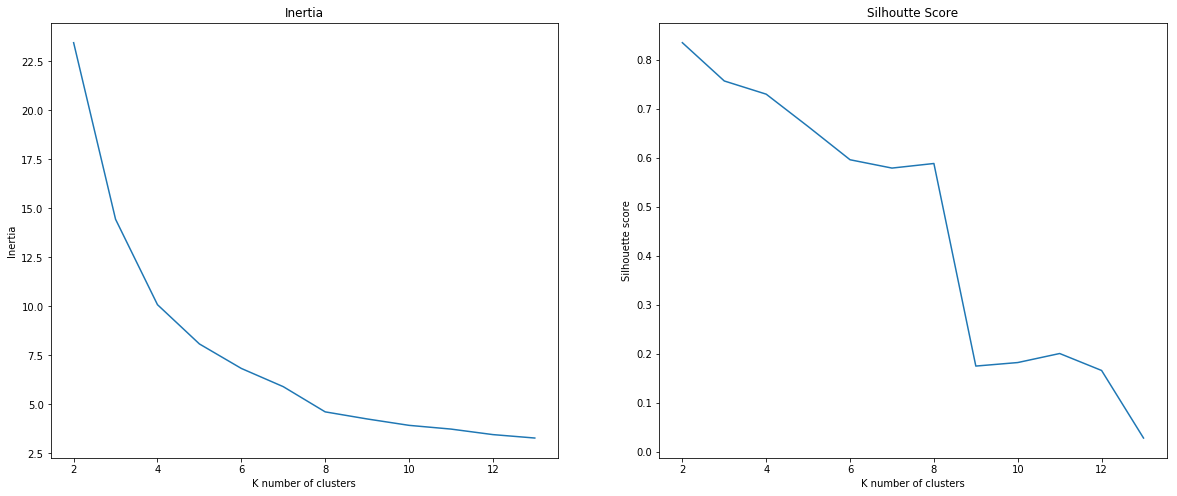

In [77]:
# set max k
max_k = 13
k_values = np.arange(2,max_k+1)
s_scores = []
inertias = []
predictions = {} # empty dictionary to kold predicitons with k value as a key

# loop through several values of k and calcualte silhoutte score
for k in k_values:
    # initialize model
    kmeans = KMeans(n_clusters=k, random_state=40, n_init=20)
    # cluster the freq df
    kmeans.fit(freq_df)
    # get the labels
    labels = kmeans.labels_
    predictions[f'k={k}'] = labels
    
    # calculate silhoutte score
    s_score = silhouette_score(freq_df, labels)
    s_scores.append(s_score)
    # append inertias
    inertias.append(kmeans.inertia_)

# plot the values to look for inflection point in inertia and for high silhoutte score
fig = plt.figure(figsize=(20,8))

# plot the inertias
ax1 = fig.add_subplot(121)
ax1.plot(k_values, inertias)
ax1.set_title('Inertia')
ax1.set_xlabel('K number of clusters')
ax1.set_ylabel('Inertia')

# plot the sillhoutte score
ax2 = fig.add_subplot(122)
ax2.plot(k_values, s_scores)
ax2.set_title('Silhoutte Score')
ax2.set_xlabel('K number of clusters')
ax2.set_ylabel('Silhouette score')

### Model Performance Analysis
After running the model multiple times, there usually isn't a clear cut best k. There's rarely see a sharp elbow on the inertia graph, and the silhoutte score usually ranges between 0.2 and 0.3. There might be a slight elbow point between k=6 and k=8, so let's use something in that range.

However, this data could be sparse too sparse for k means. There are over 180 different categories, and many of the categories only show up once. Furthermore, some post codes only had a few venues returned. This isn't ideal for kmeans. For future analysis, we could try setting a threshold for minimum number of venues in a post code. We could also try to cluster with DBSCAN, which could detect outliers.

In [83]:
# get the desired predictions
best_predictions = predictions['k=7']
best_predictions

array([2, 4, 0, 3, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0], dtype=int32)

In [84]:
# add the cluster labels to a new column in the df
freq_df['Cluster group'] = best_predictions
# only keep the cluster labels column
clabels_df = freq_df[['Cluster group']]
# merge the labels with our previous df
clustered_df = pd.merge(hood_categories_df, clabels_df, on='Postcode')
clustered_df

,Postcode,Borough,Neighbourhood,Latitude,Longitude,"Population, 2016","Total private dwellings, 2016","Private dwellings occupied by usual residents, 2016",1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster group
0,M2N,North York,Willowdale South,43.770120,-79.408493,75897,36123,33765,Coffee Shop,Ramen Restaurant,Sushi Restaurant,Café,Sandwich Place,Pizza Place,Vietnamese Restaurant,Indonesian Restaurant,Bubble Tea Shop,Discount Store,0
1,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,66108,20957,20230,Fast Food Restaurant,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
2,M2J,North York,"Fairview, Henry Farm, Oriole",43.778517,-79.346556,58293,22524,21876,Clothing Store,Coffee Shop,Fast Food Restaurant,Japanese Restaurant,Women's Store,Bakery,Food Court,Tea Room,Sporting Goods Shop,Deli / Bodega,0
3,M9V,Etobicoke,"Albion Gardens, Beaumond Heights, Humbergate, ...",43.739416,-79.588437,55959,17590,16808,Sandwich Place,Pizza Place,Pharmacy,Liquor Store,Grocery Store,Fried Chicken Joint,Fast Food Restaurant,Beer Store,NaN,NaN,0
4,M1V,Scarborough,"Agincourt North, L'Amoreaux East, Milliken, St...",43.815252,-79.284577,54680,16449,16092,Playground,Park,Coffee Shop,Arts & Crafts Store,NaN,NaN,NaN,NaN,NaN,NaN,0
5,M5V,Downtown Toronto,"CN Tower, Bathurst Quay, Island airport, Harbo...",43.628947,-79.394420,49195,35058,30726,Airport Service,Airport Terminal,Airport Lounge,Sculpture Garden,Harbor / Marina,Boutique,Boat or Ferry,Bar,Airport Gate,Airport Food Court,0
6,M1W,Scarborough,L'Amoreaux West,43.799525,-79.318389,48471,16597,16173,Fast Food Restaurant,Chinese Restaurant,Sandwich Place,Pizza Place,Pharmacy,Nail Salon,Grocery Store,Furniture / Home Store,Coffee Shop,Breakfast Spot,0
7,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029,48434,18620,17930,Discount Store,Department Store,Convenience Store,Coffee Shop,Bus Station,NaN,NaN,NaN,NaN,NaN,0
8,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,46943,17637,17161,Rental Car Location,Pizza Place,Mexican Restaurant,Medical Center,Intersection,Electronics Store,Breakfast Spot,NaN,NaN,NaN,0
9,M4C,East York,Woodbine Heights,43.695344,-79.318389,46866,20178,19431,Skating Rink,Video Store,Pharmacy,Park,Curling Ice,Cosmetics Shop,Bus Stop,Beer Store,NaN,NaN,0


# Visualization
## Now that we've gathered our data, let's visulalize our findings on a map

In [85]:
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors

In [108]:
# define function to create circle markers
def create_circle_markers(row, map_object):
    '''
    Meant to be used with .apply(). Takes a row of a df and generates the circle markers for each postcode
    '''
    # define variables from df
    pCode = row['Postcode'] 
    cluster = row['Cluster group']
    lat = row['Latitude']
    long = row['Longitude']
    hoods = row['Neighbourhood']
    
    # set marker colors
    marker_colors = ['red', 'orange', 'yellow', 'green', 'blue', 'indigo', 'violet', 'pink']
    
    # join the top 3 categories into a single string to add to the popup. If there's less than 3, only print the top categories
    try:
        topCats = ', '.join(row[['1st Most Common Venue', '2nd Most Common Venue', '3rd Most Common Venue']])
    except:
        try: 
            topCats = ', '.join(row[['1st Most Common Venue', '2nd Most Common Venue']])
        except:
            topCats = row['1st Most Common Venue']
            
    
    # define label for popup
    label = folium.Popup(html=f'Post code: {pCode}<br>Cluster: {cluster}<br><br>Top Venue Types:<br>{topCats}', parse_html=False)
    
    # create marker
    folium.CircleMarker(
        [lat, long],
        radius=6,
        popup=label,
        color = 'black',
        fill = True,
        fill_color = marker_colors[cluster],
        fill_opacity=0.69, # nice
        min_width = 9000000
       ).add_to(map_object)

In [109]:
# Set starting coordinates to the meadian of the postcode coordinates
location = [clustered_df['Latitude'].median(), clustered_df['Longitude'].median()]

# Create new map
test_map = folium.Map(location=location, zoom_start=10)

# call userdefined function with .apply. This will iterate over the df and feed each row to our function to create marker circles
clustered_df.apply(lambda x: create_circle_markers(x, test_map), axis=1)

# show map
test_map

# Observations
Diversity defines the largest cluster of Toronto postal codes. These areas typically have access to wide varieties of restaurants and entertainment options. These areas tend to be clustered towards the harbor. There seems to be a lot going on in these areas, and it doesn't seem like one type of venue defines these places. Anecdotally, it seems seafood and sushi restaurants are more highly reccomended closer to the waterfront, and while this makes intuitive sense, there was no correlation observed in the clustering.

Park access defines the next clearest cluster of Toronto neighborhoods. Geographically, these areas are still in the middle of Toronto, but they probably ahve parks within them. It's possible that people in thes areas prefer the parks to other venues, beacause the parks were the only consistently reccomended venue in this cluster.

Away from the heart of the city, we start seeing some differnt characteristics in neighborhoods. Foursquare seems to have fewer reccomendations for these areas, so the options seem more limited. For instance, one of these clusters is solely defined by fast food, while another cluster is solely defined by a piano bar. There was also a cluster defined by having a playground reccomended: psotcode M1J. This area could have a higher proportion of families.